In [ ]:
# Check for GPU and install dependencies
import torch
print("GPU available?", torch.cuda.is_available())

GPU available? True


BPE Tokenizer

In [ ]:
import math
import random
import numpy as np
from collections import Counter
import math
import random
import numpy as np
from collections import Counter
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
class BytePairEncoding:
    def __init__(self, vocab_size=5000):
        self.vocab_size = vocab_size
        self.bpe_codes = {}
        self.vocab = None
        self.bpe_vocab = None
        self.pad_token = '<PAD>'
        self.unk_token = '<UNK>'
        self.sos_token = '<SOS>'
        self.eos_token = '<EOS>'
        self.special_tokens = [
            self.pad_token, self.unk_token, self.sos_token, self.eos_token
        ]
    def get_vocab(self):
        return self.vocab
    def fit(self, sentences):
        vocab = Counter()
        for line in sentences:
            tokens = list(line.strip()) + ['</w>']
            vocab[tuple(tokens)] += 1
        self.bpe_vocab = vocab
        for _ in range(self.vocab_size - len(self.special_tokens)):
            pairs = Counter()
            for word, freq in vocab.items():
                for i in range(len(word) - 1):
                    pairs[(word[i], word[i+1])] += freq
            if not pairs:
                break
            bigram = pairs.most_common(1)[0][0]
            new_vocab = Counter()
            for word, freq in vocab.items():
                new_word = []
                i = 0
                while i < len(word):
                    if i < len(word) - 1 and (word[i], word[i+1]) == bigram:
                        new_word.append(word[i]+word[i+1])
                        i += 2
                    else:
                        new_word.append(word[i])
                        i += 1
                new_vocab[tuple(new_word)] += freq
            vocab = new_vocab
            self.bpe_codes[bigram] = bigram[0]+bigram[1]
        tokens = set()
        for word in vocab:
            for token in word:
                tokens.add(token)
        self.vocab = {t: idx for idx, t in enumerate(self.special_tokens + sorted(tokens))}
        self.unk_idx = self.vocab[self.unk_token]
        self.pad_idx = self.vocab[self.pad_token]
        self.sos_idx = self.vocab[self.sos_token]
        self.eos_idx = self.vocab[self.eos_token]
    def encode(self, sentence):
        sentence = list(sentence.strip()) + ['</w>']
        while True:
            pairs = [(sentence[i], sentence[i+1]) for i in range(len(sentence)-1)]
            pairs = [p for p in pairs if p in self.bpe_codes]
            if not pairs:
                break
            bigram = pairs[0]
            new_sentence = []
            i = 0
            while i < len(sentence):
                if i < len(sentence) - 1 and (sentence[i], sentence[i+1]) == bigram:
                    new_sentence.append(sentence[i]+sentence[i+1])
                    i += 2
                else:
                    new_sentence.append(sentence[i])
                    i += 1
            sentence = new_sentence
        return [self.vocab.get(token, self.unk_idx) for token in sentence]
    def decode(self, ids):
        rev_vocab = {idx: token for token, idx in self.vocab.items()}
        tokens = [rev_vocab.get(idx, self.unk_token) for idx in ids]
        return ''.join([t for t in tokens if t not in self.special_tokens])

Dataset and DataLoader

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, encoded_text, seq_len):
        self.data = encoded_text
        self.seq_len = seq_len
    def __len__(self):
        return len(self.data) - self.seq_len
    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx:idx+self.seq_len], dtype=torch.long)
        y = torch.tensor(self.data[idx+1:idx+self.seq_len+1], dtype=torch.long)
        return x, y

Processing the Dataset (Tokenizing, encoding, and then splitting)

previous first 90 train last 10 val

In [ ]:
# data_path = "/content/Pride_and_Prejudice-Jane_Austen.txt"
# with open(data_path, 'r', encoding='utf-8') as f:
#     text = f.read()

# bpe = BytePairEncoding(vocab_size=800)  # You can adjust vocab_size here
# bpe.fit(text.splitlines())
# encoded = []
# for line in text.splitlines():
#     encoded.extend(bpe.encode(line))

# def train_val_split(encoded, split=0.9):
#     n = int(len(encoded) * split)
#     return encoded[:n], encoded[n:]

# train_enc, val_enc = train_val_split(encoded, split=0.9)

new one random line by line

In [ ]:
import random

# 1. Read text
data_path = "/content/Pride_and_Prejudice-Jane_Austen.txt"
with open(data_path, 'r', encoding='utf-8') as f:
    lines = [line.strip() for line in f if line.strip()]

# 2. Shuffle lines to mix early/mid/late chapters
random.seed(42)
random.shuffle(lines)

# 3. Fit BPE tokenizer only on training portion (optional)
split_idx = int(0.9 * len(lines))
train_lines, val_lines = lines[:split_idx], lines[split_idx:]

# 4. Train tokenizer on training lines
bpe = BytePairEncoding(vocab_size=800)
bpe.fit(train_lines)

# 5. Encode both train and val sets
train_enc, val_enc = [], []
for line in train_lines:
    train_enc.extend(bpe.encode(line))
for line in val_lines:
    val_enc.extend(bpe.encode(line))
encoded = train_enc + val_enc

In [ ]:
import pickle

# Save tokenizer object
with open("/content/bpe_tokenizer.pkl", "wb") as f:
    pickle.dump(bpe, f)

print("✅ Tokenizer saved successfully at /content/bpe_tokenizer.pkl")

✅ Tokenizer saved successfully at /content/bpe_tokenizer.pkl


In [ ]:
import json

# Save vocab dictionary
with open("/content/bpe_vocab.json", "w", encoding="utf-8") as f:
    json.dump(bpe.vocab, f, ensure_ascii=False, indent=2)

# If your BPE class has merges, save them too
if hasattr(bpe, "merges"):
    with open("/content/bpe_merges.json", "w", encoding="utf-8") as f:
        json.dump(bpe.merges, f, ensure_ascii=False, indent=2)

print("✅ Saved vocabulary and merges as JSON files.")

✅ Saved vocabulary and merges as JSON files.


In [ ]:
# Print vocabulary size information
print(f"Target vocab_size: 800")
print(f"Actual vocab_size: {len(bpe.vocab)}")
print(f"Number of special tokens: 4 (PAD, UNK, SOS, EOS)")
print(f"Number of BPE tokens learned: {len(bpe.vocab) - 4}")
print(f"Total encoded tokens: {len(encoded)}")
print(f"Train tokens: {len(train_enc)}, Val tokens: {len(val_enc)}")

Target vocab_size: 800
Actual vocab_size: 880
Number of special tokens: 4 (PAD, UNK, SOS, EOS)
Number of BPE tokens learned: 876
Total encoded tokens: 334616
Train tokens: 300855, Val tokens: 33761


Transformer model

In [ ]:
import torch
import torch.nn as nn
import math

class CausalSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super().__init__()
        assert embed_dim % num_heads == 0
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = math.sqrt(self.head_dim)

        self.key = nn.Linear(embed_dim, embed_dim)
        self.query = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.size()
        # Linear projections
        k = self.key(x).view(B, T, self.num_heads, self.head_dim).transpose(1,2)  # (B, nh, T, hs)
        q = self.query(x).view(B, T, self.num_heads, self.head_dim).transpose(1,2)
        v = self.value(x).view(B, T, self.num_heads, self.head_dim).transpose(1,2)
        scores = (q @ k.transpose(-2, -1)) / self.scale  # (B, nh, T, T)
        # Causal mask: only allow attending to current-and-previous positions
        mask = torch.triu(torch.ones(T, T, device=x.device), diagonal=1).bool()
        scores = scores.masked_fill(mask, float('-inf'))
        attn = torch.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        y = attn @ v  # (B, nh, T, hs)
        y = y.transpose(1,2).contiguous().view(B, T, C)
        return self.proj(y)

In [ ]:
class TransformerDecoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.1):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_dim)
        self.self_attn = CausalSelfAttention(embed_dim, num_heads, dropout)
        self.dropout1 = nn.Dropout(dropout)
        self.ln2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, embed_dim),
            nn.Dropout(dropout)
        )
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        # Residual connection 1 (Self Attention)
        attn_out = self.self_attn(self.ln1(x))
        x = x + self.dropout1(attn_out)
        # Residual connection 2 (MLP)
        x = x + self.dropout2(self.mlp(self.ln2(x)))
        return x

In [ ]:
class TransformerLM(nn.Module):
    def __init__(self, vocab_size, seq_len, embed_dim, num_heads, mlp_dim, nlayers, dropout=0.6):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        # self.emb_dropout = nn.Dropout(0.1)
        self.pos_embed = nn.Parameter(torch.zeros(1, seq_len, embed_dim))
        nn.init.normal_(self.pos_embed, mean=0.0, std=0.02)
        self.blocks = nn.ModuleList([
            TransformerDecoderBlock(embed_dim, num_heads, mlp_dim, dropout)
            for _ in range(nlayers)
        ])
        self.ln_f = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, vocab_size)

    def forward(self, x):
        B, T = x.size()
        token_emb = self.embed(x)  # shape: (B, T, E)
        # token_emb = self.emb_dropout(token_emb)
        x = token_emb + self.pos_embed[:, :T, :]
        for block in self.blocks:
            x = block(x)
        x = self.ln_f(x)
        logits = self.head(x)  # (B, T, V)
        return logits

In [ ]:
SEQ_LEN = 128
BATCH_SIZE = 64

train_dataset = TextDataset(train_enc, SEQ_LEN)
val_dataset = TextDataset(val_enc, SEQ_LEN)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

VOCAB_SIZE = len(bpe.vocab)
EMB_DIM = 256      # larger embeddings
NHEAD = 8          # more attention heads
NLAYERS = 4        # deeper transformer
FF_DIM = 1024      # larger feed-forward layers
DROPOUT = 0.0     # heavy regularization

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerLM(
    vocab_size=VOCAB_SIZE,
    seq_len=SEQ_LEN,
    embed_dim=EMB_DIM,
    num_heads=NHEAD,
    mlp_dim=FF_DIM,
    nlayers=NLAYERS,
    dropout=DROPOUT
).to(device)

Training and Validation Loop

Epoch 1: Train Loss=3.5608 | Val Loss=3.4559 | Perplexity=31.69
Epoch 2: Train Loss=3.1637 | Val Loss=3.0284 | Perplexity=20.66
Epoch 3: Train Loss=2.7670 | Val Loss=2.8102 | Perplexity=16.61
Epoch 4: Train Loss=2.4939 | Val Loss=2.7914 | Perplexity=16.30
Epoch 5: Train Loss=2.2966 | Val Loss=2.8454 | Perplexity=17.21
Epoch 6: Train Loss=2.1226 | Val Loss=2.9531 | Perplexity=19.17
Epoch 7: Train Loss=1.9418 | Val Loss=3.1108 | Perplexity=22.44
Epoch 8: Train Loss=1.7662 | Val Loss=3.3037 | Perplexity=27.21
Epoch 9: Train Loss=1.6102 | Val Loss=3.4714 | Perplexity=32.18
Epoch 10: Train Loss=1.4788 | Val Loss=3.6454 | Perplexity=38.30


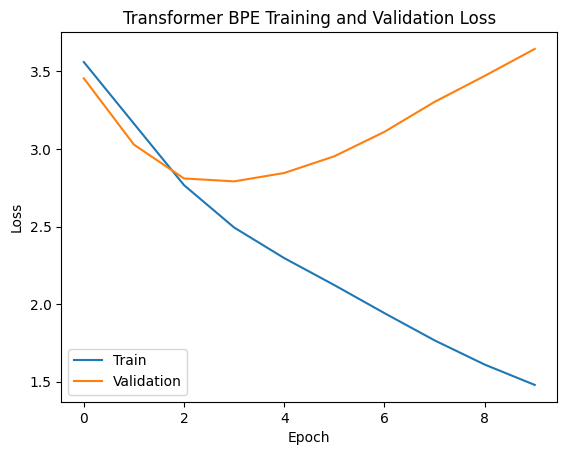

In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt

N_EPOCHS = 10
optimizer = optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index=bpe.pad_idx)

train_losses, val_losses = [], []

def compute_perplexity(loss):
    return math.exp(loss)

for epoch in range(N_EPOCHS):
    model.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out.view(-1, out.size(-1)), yb.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = criterion(out.view(-1, out.size(-1)), yb.view(-1))
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f} | Val Loss={avg_val_loss:.4f} | Perplexity={compute_perplexity(avg_val_loss):.2f}")

# Plot losses
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Transformer BPE Training and Validation Loss')
plt.legend()
plt.show()

Saving the model

In [ ]:
# Save the trained model weights
torch.save(model.state_dict(), "transformer_overfit.pth")

# Download if needed
from google.colab import files
files.download("transformer_overfit.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>